# Periscope Correction Current State

In 2010, 15 observations with both relatively bright sources and larger periscope gradient changes were used to generate a periscope gradient calibration.  This calibration was applied as a correction to the fiducial light positions directly.  See http://occweb.cfa.harvard.edu/twiki/Aspect/PeriscopeTilt  This correction is applied as part of current processing and was applied to historical observations as part of ReproIV efforts.

As mentioned, however, the correction was only calibrated with 15 observations with larger drifts, and current anecdotal observations 6 years later demonstrate uncorrected periscope drift effects.  So, to start, we want to gather new data and evaluate the "goodness" of the 2010 calibration against new data.  To do so we:

 - Get a new data set with both relatively on-axis bright point sources and large(r) expected periscope drifts
 - Evaluate X-ray event drift in Y and Z in this data set
 

## Get new data set

In [49]:
%pylab inline
import os
from IPython.display import Image
from astropy.table import Table
import cPickle

Populating the interactive namespace from numpy and matplotlib


Run code that finds "tilted" observations, runs celldetect, gets the brightest source that is also pretty-much on-axis, and extracts events in a circular region around those sources.  The on-axis limit is set at a radial distance of 180 pixels.

In [1]:
import tilt.find_sources
tilt.find_sources.get_xray_data()

Fetching obsids using query 'select obsid from obs_periscope_tilt where max_oobagrd3 - min_oobagrd3 > .125 order by (max_oobagrd3 - min_oobagrd3) desc'
Looking for sources in these 281 observations
Retrieved sources for 249 observations


Run one script that makes ds9 preview images of the sources, and another that quickly lets one manually review those images.  review_images is set to only review sources that show up with 2500 counts or more.

In [ ]:
# run tilt/make_check_images.py
# run tilt/review_images.py

For each source, we have several useful files in the obsid directories.  

- picked_src.dat information from celldetect about the picked/selected source
- point_source.fits dmcopy/extracted region of events from evt2 file from the observation
- point_stat.dat text file with True or False indicating point-source-ness from manual review
- released_pos.pkl Y,Z positions of events in the circular region extracted around the source

In [2]:
!ls auto/obs17128

17128_src2.fits       center.reg    picked_src.dat     pos.pkl
bin_mean_10k_yag.pkl  ds9_src.png   point_source.fits  released_pos.pkl
bin_mean_10k_zag.pkl  evtinfo.json  point_stat.dat     tilt.pkl


And a master file with the sources

In [14]:
srcs = Table.read('src_table.dat', format='ascii')
print srcs[['obsid','NET_COUNTS','point_source']][:1]

obsid   NET_COUNTS  point_source
----- ------------- ------------
17128 5794.57128906         True


## Evaluate 

In [21]:
# this would probably be nicer with scipy.stats.binned_statistic, but that doesn't
# give me nice error bars, and this was hanging around
def binned_mean(data, evtstime, tbin=10000.):
    ts = []
    ds = []
    dsminus = []
    dsplus = []
    for win_start in range(0,
                           int(evtstime[-1]-evtstime[0])-int(tbin),
                           int(tbin)):
        tmask = ((evtstime-evtstime[0] >= win_start)
                 & (evtstime-evtstime[0] < win_start + int(tbin)))
        range_data = data[tmask]
        range_time = evtstime[tmask]
        if np.std(range_data) > 0:
            ds.append(np.mean(range_data))
            dsminus.append(np.std(range_data)/np.sqrt(len(range_data)))
            dsplus.append(np.std(range_data)/np.sqrt(len(range_data)))
            t = np.mean(range_time)
            ts.append(t)
    return [ts, ds, dsminus, dsplus]

First, here's a demo image of one of these 'pointy' sources:

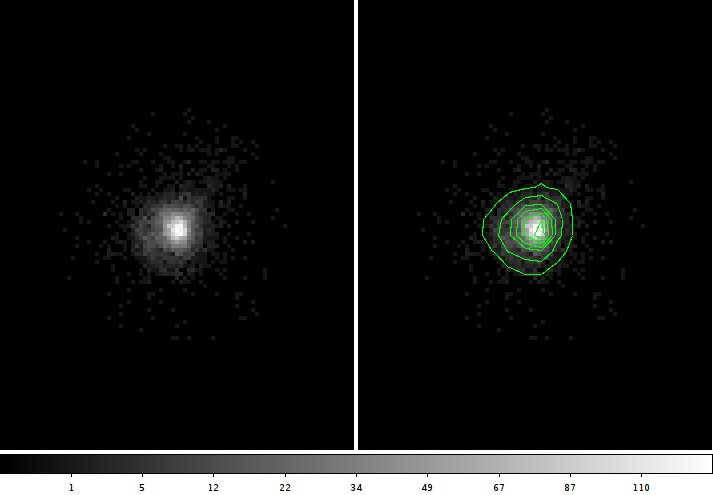

In [99]:
obsid = 17128
Image("auto/obs{:05d}/ds9_src.png".format(obsid))

And if we plot up the Y-angle position of the events binned by time there does appear to be drift.

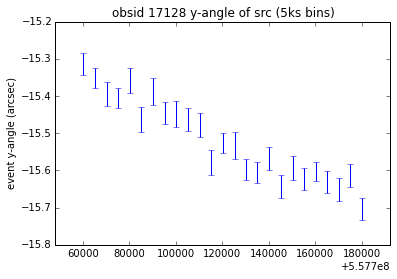

In [100]:
obsid = 17128
pos = cPickle.load(open('auto/obs{:05d}/released_pos.pkl'.format(obsid)))
ts, ds, dsminus, dsplus = binned_mean(pos['yag'], pos['time'], 5000)
errorbar(ts, ds, yerr=dsminus, linestyle='');
ylabel('event y-angle (arcsec)')
margins(x=.1)
title('obsid {} y-angle of src (5ks bins)'.format(obsid));

We basically care about this in aggregate for this whole source set, about each sources mean position.  First, just this source:

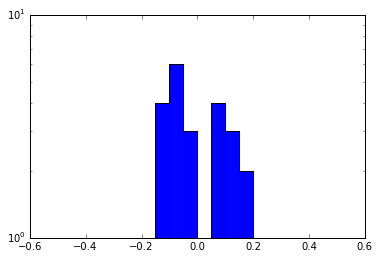

In [101]:
hist(ds - np.mean(ds), bins=arange(-.5, .5, .05), log=True);

In [102]:
# then all of the sources we've marked as point sources thus far with NET_COUNTS > 2500
residuals = []
obsids = []
binsize = 5000
ax = 'yag'
for obsid in srcs[(srcs['NET_COUNTS'] > 2500) & (srcs['point_source'] == 'True')]['obsid']:
    pkl = 'auto/obs{:05d}/released_pos.pkl'.format(obsid)
    if not os.path.exists(pkl):
        continue
    pos = cPickle.load(open(pkl))
    ts, ds, dsminus, dsplus = binned_mean(pos[ax], pos['time'], binsize)
    residuals.extend((ds - np.mean(ds)).tolist())
    obsids.extend(np.repeat(obsid, len(ds)))
obsids = np.array(obsids)
residuals = np.array(residuals)

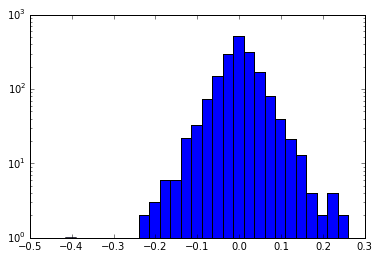

In [105]:
step = 0.025
hist(residuals, bins=arange(np.min(residuals), np.max(residuals) + step, step), log=True);

In [107]:
last_cal_observations = [10062, 10227, 10228, 11075, 11260, 11688, 11823, 12088, 5003,
                         7077, 7079, 8922, 9133, 9218, 9407, 9532]

In [118]:
from Ska.DBI import DBI
sqlaca = DBI(dbi='sybase', server='sybase', user='aca_read')
old_gradients = sqlaca.fetchall("""select obsid, max_oobagrd3 - min_oobagrd3 as grad_diff
from obs_periscope_tilt
where obsid in ({})""".format(",".join([str(o) for o in last_cal_observations])))

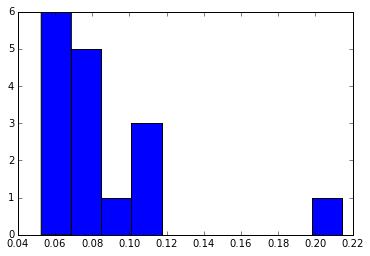

In [121]:
hist(old_gradients['grad_diff']);

In [127]:
cal_srcs = srcs[(srcs['NET_COUNTS'] > 2500) & (srcs['point_source'] == 'True')]
all_gradients = sqlaca.fetchall("""select max_oobagrd3 - min_oobagrd3 as grad_diff
from obs_periscope_tilt
where obsid in ({})""".format(",".join([str(o) for o in cal_srcs['obsid']])))

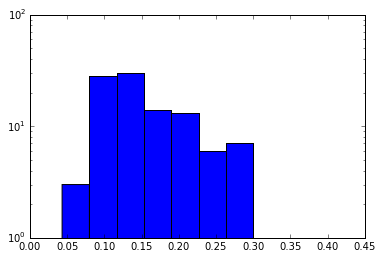

In [128]:
hist(all_gradients['grad_diff'], log=True);

So, we confirm that there are both uncorrected offsets and a much larger range of periscope drifts available.

## Setup for new fit

Because all of the current solutions are already corrected, we can either fit for an additive correction on the current model, or we can back out the current correction and fit new terms on "raw" data.  I have preferred the second.  There are actually two ways to kind of get at the "raw" data.  The strict method would be to rerun the aspect pipeline on all observations with the periscope correction disabled, and then repeat this source extraction.  A more time-efficient method is to reverse the correction on the X-ray event Y and Z positions directly, which is what I have done.  I have, however, confirmed that the positions via this direct method are very very close to what you get if you run acis_process_events on these events using an aspect solution with the periscope correction disabled.  Let's walk through that.